# Logistic Regression for Multiple Products

In [1]:
import math
import operator
import itertools
import numpy as np
import sklearn.linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

## Konstanten

In [2]:
# General parameters
min_price = 1
max_price = 20
price_step = 0.1
prices_ranges = [np.arange(min_price, max_price + price_step, price_step) for i in range(2)]
competitors_count = 2

# Regression parameters
observations_count = 1000

# Optimization parameters
delta = 0.99
holding_cost_rate = [0.01, 0.01]
init_inventory = [3, 3]
optimization_steps = 10
simulation_length = 10

## Simulierte Daten

In [3]:
def generate_prices(prices_range, count):
    return np.random.choice(prices_range, count)

def generate_competitor_prices(prices_range):
    return np.array([generate_prices(prices_range, observations_count) for j in range(competitors_count)])
    
def calculate_ranks(prices, competitor_prices):
    return [1 + len([1 for j in range(competitors_count) if competitor_prices[j, k] < prices[k]])
            for k in range(observations_count)]

def boost_price(boost_factor, price):
    return min(20, round((1 + boost_factor) * price, 1))

def price_index(price):
    return int(price / price_step - min_price / price_step)

In [4]:
prices = np.array([generate_prices(prices_ranges[i], observations_count) for i in range(2)]) 
competitor_prices = np.array([generate_competitor_prices(prices_ranges[i]) for i in range(2)])

"""
# Boost prices for product A
for k in range(observations_count):
    prices[0, k] = boost_price(0.4, prices[0, k])
    for j in range(competitors_count):
        competitor_prices[0, j, k] = boost_price(0.4, competitor_prices[0, j, k])
"""

ranks = np.array([calculate_ranks(prices[i], competitor_prices[i]) for i in range(2)])

In [5]:
def calculate_sale_probs_A(prices, ranks):
    max_prob = lambda i: 1 - ((0.3 * ranks[0, i]) / (competitors_count + 1)) - \
                         0.05 * prices[0, i] + \
                         (-0.0125 * (prices[0, i] - prices[1, i]) + 0.25)
            
    return [max(0, round(np.random.uniform(0, max_prob(i)))) for i in range(observations_count)]

def calculate_sale_probs_B(prices, ranks):
    max_prob = lambda i: 1 - ((0.3 * ranks[1, i]) / (competitors_count + 1)) - \
                         0.05 * prices[1, i] + \
                         (0.0125 * (prices[0, i] - prices[1, i]) + 0.25)
            
    return [max(0, round(np.random.uniform(0, max_prob(i)))) for i in range(observations_count)]

In [6]:
"""
def calculate_sale_probs_A(prices, competitor_prices, ranks):
    sum_competitors_A = lambda k: sum(competitor_prices[0, j, k] for j in range(competitors_count))
    sum_competitors_B = lambda k: sum(competitor_prices[1, j, k] for j in range(competitors_count))
    max_prob = lambda k: 1 - (0.4 / max_price) * prices[0, k] \
                           + (0.2 / max_price) * prices[1, k] \
                           + (0.3 / max_price) * sum_competitors_A(k) / competitors_count \
                           + (0.1 / max_price) * sum_competitors_B(k) / competitors_count
    
    return [max(0, round(np.random.uniform(0, max_prob(k)))) for k in range(observations_count)]

def calculate_sale_probs_B(prices, competitor_prices, ranks):
    sum_competitors_A = lambda k: sum(competitor_prices[0, j, k] for j in range(competitors_count))
    sum_competitors_B = lambda k: sum(competitor_prices[1, j, k] for j in range(competitors_count))
    max_prob = lambda k: 1 + (0.2 / max_price) * prices[0, k] \
                           - (0.4 / max_price) * prices[1, k] \
                           + (0.1 / max_price) * sum_competitors_A(k) / competitors_count \
                           + (0.3 / max_price) * sum_competitors_B(k) / competitors_count
    
    return [max(0, round(np.random.uniform(0, max_prob(k)))) for k in range(observations_count)]
"""

'\ndef calculate_sale_probs_A(prices, competitor_prices, ranks):\n    sum_competitors_A = lambda k: sum(competitor_prices[0, j, k] for j in range(competitors_count))\n    sum_competitors_B = lambda k: sum(competitor_prices[1, j, k] for j in range(competitors_count))\n    max_prob = lambda k: 1 - (0.4 / max_price) * prices[0, k]                            + (0.2 / max_price) * prices[1, k]                            + (0.3 / max_price) * sum_competitors_A(k) / competitors_count                            + (0.1 / max_price) * sum_competitors_B(k) / competitors_count\n    \n    return [max(0, round(np.random.uniform(0, max_prob(k)))) for k in range(observations_count)]\n\ndef calculate_sale_probs_B(prices, competitor_prices, ranks):\n    sum_competitors_A = lambda k: sum(competitor_prices[0, j, k] for j in range(competitors_count))\n    sum_competitors_B = lambda k: sum(competitor_prices[1, j, k] for j in range(competitors_count))\n    max_prob = lambda k: 1 + (0.2 / max_price) * prices[

In [7]:
sale_probs = [calculate_sale_probs_A(prices, ranks),
              calculate_sale_probs_B(prices, ranks)]

## Regression

In [8]:
def get_all_competitor_prices(observation):
    for i in range(2):
            for j in range(competitors_count):
                yield competitor_prices[i, j, observation]
                
def get_explanatory_vars(product, ranks, competitor_prices):
    explanatory_1 = [1] * observations_count
    explanatory_2 = [ranks[product, k] for k in range(observations_count)]
    explanatory_3 = [prices[product, k] - min(get_all_competitor_prices(k)) for k in range(observations_count)]
    explanatory_4 = [prices[product, k] - min(prices[i, k] for i in range(2)) for k in range(observations_count)]
    explanatory_5 = list(map(lambda x: math.pow(x, 2),explanatory_4))
    
    return np.matrix([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])

In [9]:
explanatory_vars = [get_explanatory_vars(i, ranks, competitor_prices) for i in range(2)]
logits = [sm.Logit(sale_probs[i], explanatory_vars[i].transpose()) for i in range(2)]
results = [logits[i].fit() for i in range(2)]
beta = [results[i].params for i in range(2)]
beta

Optimization terminated successfully.
         Current function value: 0.336429
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.347717
         Iterations 12


[array([ 0.84199303, -0.94863448, -0.08965665, -0.4074441 , -0.0089442 ]),
 array([ 0.86702103, -0.72427527, -0.11841878, -0.27282325, -0.04790339])]

In [10]:
[results[i].aic for i in range(2)]

[682.85836862940153, 705.43461309971281]

## Optimierung

In [11]:
# Generate competitor prices for new, specific situation
competitor_prices = np.array([generate_prices(prices_ranges[i], competitors_count) for i in range(2)])

### Recreate explanatory vars depending on price combinations

In [12]:
def get_all_competitor_prices():
    for i in range(2):
        for k in range(competitors_count):
            yield competitor_prices[i][k]

def get_explanatory_vars_replica_A(competitor_prices):
    explanatory_1 = np.array([[1] * len(prices_ranges[0])] * len(prices_ranges[1]))
    explanatory_2 = np.array([[1 + len([1 for j in range(competitors_count) if competitor_prices[0, j] < price_A]) 
                               for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_3 = np.array([[price_A - min(get_all_competitor_prices()) 
                               for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_4 = np.array([[price_A - min([price_A, price_B]) 
                                for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_5 = np.array([[math.pow(explanatory_4[price_index(price_A), price_index(price_B)], 2) 
                                for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    
    return np.array([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])

def get_explanatory_vars_replica_B(competitor_prices):
    explanatory_1 = np.array([[1] * len(prices_ranges[0])] * len(prices_ranges[1]))
    explanatory_2 = np.array([[1 + len([1 for j in range(competitors_count) if competitor_prices[1, j] < price_B]) 
                               for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_3 = np.array([[price_B - min(get_all_competitor_prices()) 
                               for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_4 = np.array([[price_B - min([price_A, price_B]) 
                                for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_5 = np.array([[math.pow(explanatory_4[price_index(price_A), price_index(price_B)], 2) 
                                for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    
    return np.array([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])

In [13]:
explanatory_vars = [get_explanatory_vars_replica_A(competitor_prices),
                    get_explanatory_vars_replica_B(competitor_prices)]

### Calculate sale probabilities with betas

In [24]:
def calculate_sale_probs(beta, explanatory_vars):
    sale_probs = np.empty(shape=(2, 2, len(prices_ranges[0]), len(prices_ranges[1])))
    for i in range(2):
        for price_A in prices_ranges[0]:
            for price_B in prices_ranges[1]:
                L = sum([beta[i][l] * explanatory_vars[i][l, price_index(price_A), price_index(price_B)] for l in range(len(beta[i]))])
                p = np.exp(L) / (1 + np.exp(L))
                sale_probs[0, i, price_index(price_A), price_index(price_B)] = 1 - p
                sale_probs[1, i, price_index(price_A), price_index(price_B)] = p
    return sale_probs

In [25]:
sale_probs = calculate_sale_probs(beta, explanatory_vars)

### Calculate optimal prices using Bellman

In [26]:
def get_event_combinations(n):
        possibile_events = [[0] if n[i] == 0 else range(2) for i in range(2)]
        return itertools.product(*possibile_events)

def bellman(n, sale_probs, values, step):
    prob = lambda i, e, prices: sale_probs[e[i], i, price_index(prices[0]), price_index(prices[1])]
    todays_profit = lambda e, prices: sum(min(n[i], e[i]) * prices[i] - n[i] * holding_cost_rate[i] for i in range(2))
    disc_exp_fut_profits = lambda e: delta * values[step + 1, max(0, n[0] - e[0]), max(0, n[1] - e[1])]
    
    bellman_results = {}
    for prices in itertools.product(prices_ranges[0], prices_ranges[1]):
        result = sum(prob(0, e, prices) * prob(1, e, prices) * (todays_profit(e, prices) + disc_exp_fut_profits(e)) 
                     for e in get_event_combinations(n))
        bellman_results[prices] = result
    
    return max(bellman_results.items(), key=operator.itemgetter(1))

In [27]:
def bellman_new(sale_probs):
    prob = lambda i, e, prices: sale_probs[e[i], i, price_index(prices[0]), price_index(prices[1])]
    todays_profit = lambda e, prices: sum(e[i] * prices[i] for i in range(2))
    
    bellman_results = {}
    for prices in itertools.product(prices_ranges[0], prices_ranges[1]):
        result = sum(prob(0, e, prices) * prob(1, e, prices) * todays_profit(e, prices) 
                     for e in itertools.product([0,1], [0,1]))
        bellman_results[prices] = result
    
    return max(bellman_results.items(), key=operator.itemgetter(1))[0]

In [28]:
opt_prices = bellman_new(sale_probs)
print(opt_prices)

(8.4000000000000057, 8.4000000000000057)


In [29]:
"""
values = np.zeros(shape=(optimization_steps + 1, init_inventory[0] + 1, init_inventory[1] + 1))
opt_prices = np.zeros(shape=(optimization_steps + 1, init_inventory[0] + 1, init_inventory[1] + 1, 2))
for step in range(optimization_steps - 1, -1, -1):
    print('%s/%s' % (optimization_steps - step, optimization_steps))
    for n_A in range(init_inventory[0] + 1):
        for n_B in range(init_inventory[1] + 1):
            if n_A > 0 or n_B > 0:
                opt_prices[step, n_A, n_B], values[step, n_A, n_B] = bellman([n_A, n_B], sale_probs, values, step)
"""

"\nvalues = np.zeros(shape=(optimization_steps + 1, init_inventory[0] + 1, init_inventory[1] + 1))\nopt_prices = np.zeros(shape=(optimization_steps + 1, init_inventory[0] + 1, init_inventory[1] + 1, 2))\nfor step in range(optimization_steps - 1, -1, -1):\n    print('%s/%s' % (optimization_steps - step, optimization_steps))\n    for n_A in range(init_inventory[0] + 1):\n        for n_B in range(init_inventory[1] + 1):\n            if n_A > 0 or n_B > 0:\n                opt_prices[step, n_A, n_B], values[step, n_A, n_B] = bellman([n_A, n_B], sale_probs, values, step)\n"

## Simulation

In [30]:
# Competitor prices over the time period
competitor_prices_time = np.zeros(shape=(simulation_length, 2, competitors_count))
for i in range(2):
    for j in range(competitors_count):
        competitor_prices_time[0, i, j] = competitor_prices[0, j]
        
# Own prices over the time period
prices_time = np.zeros(shape=(simulation_length, 2))
prices_time[0, 0] = opt_prices[0]
prices_time[0, 1] = opt_prices[1]

# count number of sales
product_sales = np.zeros(shape=(simulation_length, 2))

In [ ]:
for step in range(1, simulation_length):
    for i in range(2):
        sale_prob = sale_probs[i, 1, price_index(prices_time[step - 1, 0]), price_index(prices_time[step - 1,1])]
        if np.random.uniform(0, 1) < sale_prob:
            product_sales[step, i] = product_sales[step-1, i] + 1
        else:
            product_sales[step, i] = product_sales[step-1, i]
    
        # TODO vary competitor prices
        for j in range(competitors_count):
            if np.random.uniform(0, 1) < 0.5:
                boost = np.random.uniform(0.8, 1.2)
                competitor_prices_time[step, i, j] = round(competitor_prices_time[step - 1, i, j] * boost, 1)
                explanatory_vars = [get_explanatory_vars_replica_A(competitor_prices_time[step]),
                                    get_explanatory_vars_replica_B(competitor_prices_time[step])]
                sale_probs = calculate_sale_probs(beta, explanatory_vars)
                opt_prices = bellman_new(sale_probs)
                prices_time[step, 0] = opt_prices[0]
                prices_time[step, 1] = opt_prices[1]
            else:
                competitor_prices_time[step, i, j] = competitor_prices_time[step-1, i, j]

### Plots

In [ ]:
swap_prices_time = np.swapaxes(prices_time, 0,1)
swap_product_sales = np.swapaxes(product_sales, 0,1)
swap_competitor_prices_time = np.swapaxes(competitor_prices_time, 0,2)

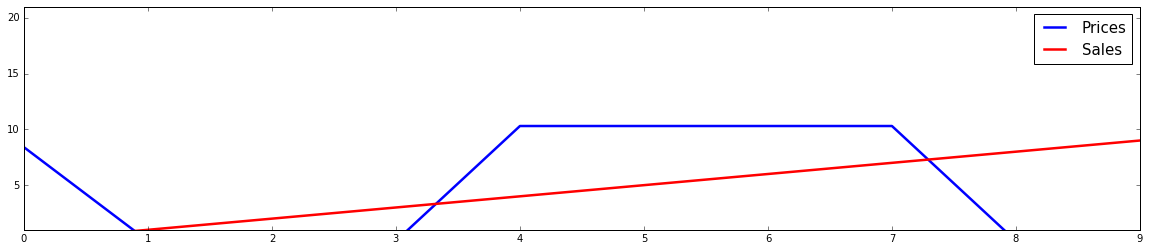

In [49]:
plt.figure(figsize=(20, 4))
plt.plot(range(simulation_length), swap_prices_time[0], label='Prices', color="blue", linewidth=2.5)
plt.plot(range(simulation_length), swap_product_sales[0], label='Sales', color="red", linewidth=2.5)
plt.axis([0, simulation_length - 1, min_price, max_price + 1])
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

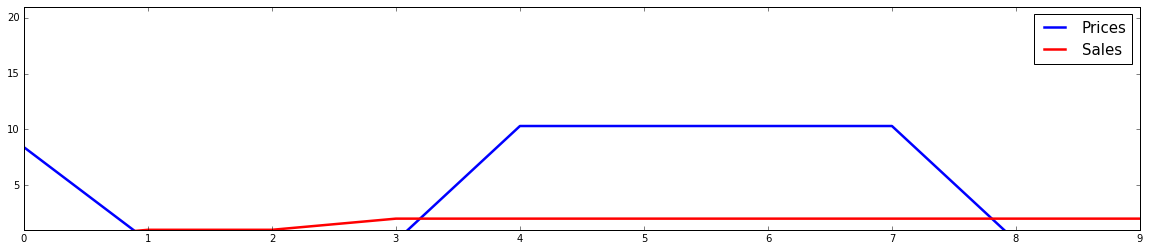

In [50]:
plt.figure(figsize=(20, 4))
plt.plot(range(simulation_length), swap_prices_time[1], label='Prices', color="blue", linewidth=2.5)
plt.plot(range(simulation_length), swap_product_sales[1], label='Sales', color="red", linewidth=2.5)
plt.axis([0, simulation_length - 1, min_price, max_price + 1])
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(range(simulation_length), swap_prices_time[0], label='Prices', linewidth=2.5)
for competitor in range(competitors_count):
    plt.plot(range(simulation_length), swap_competitor_prices_time[competitor][0], label='Competitor'+str(competitor), linewidth=2.5)
plt.axis([0, simulation_length - 1, min_price, max_price + 1])
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

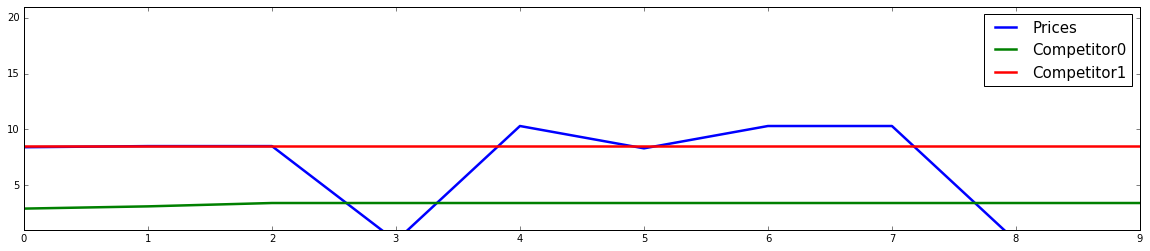

In [63]:
plt.figure(figsize=(20, 4))
plt.plot(range(simulation_length), swap_prices_time[1], label='Prices', linewidth=2.5)
for competitor in range(competitors_count):
    plt.plot(range(simulation_length), swap_competitor_prices_time[competitor][1], label='Competitor'+str(competitor), linewidth=2.5)
plt.axis([0, simulation_length - 1, min_price, max_price + 1])
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

In [65]:
competitor_prices[1]

array([ 8.4,  4.2])